# Analysis

Read data files from multiple chillers and create a model

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import RidgeCV
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error
from sklearn.linear_model    import Lasso
from sklearn                 import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt

import pickle

%matplotlib inline


# import custome utility functions
from util import plot_curves
from util import get_Xy
from util import compute_lift_lines

In [ ]:
'''
X, y = get_Xy(df1)

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)
'''

## Find the equation for the system

If 

kW/Ton = A * (1 + B x Lift) x (1 + C1 x Load + C2 x Load^2)   
kW/Ton = A*(1 + C1 x Load + B x Lift + C2 x Load^2 + B x C1 x Load x Lift + B x C2 x Load^2 x Lift)   

kW/Ton = Intercept + Coef0 x Load + Coef1 x Lift + Coef2 x Load^2 + Coef3 * Load x Lift + Coef4 x Load^2 x Lift

A = Intercept  
C1 = Coef0/A   
B = Coef1/A    
C2 = Coef2/A

Coef3 = B x C1 x A   
Coef4 = B x C2 x A

In [21]:
print(lr.intercept_, lr.coef_)

-0.004085421897932068 [ 0.50260261  0.00086912 -0.78605079  0.02227729 -0.00564851]


In [22]:
Intercept = lr.intercept_
Coef0 = lr.coef_[0]
Coef1 = lr.coef_[1]
Coef2 = lr.coef_[2]
Coef3 = lr.coef_[3]
Coef4 = lr.coef_[4]

In [23]:
type(A)

numpy.float64

In [24]:
A = Intercept
C1 = Coef0/A
B  = Coef1/A
C2 = Coef2/A

In [25]:
print(A, B, C1, C2)

-0.004085421897932068 -0.21273737425578235 -123.02342776939253 192.40382355061763


In [26]:
print(Coef4, B*C2*A)
print(Coef3, B*C1*A)

-0.005648506528492979 0.1672223819428826
0.02227728643293194 -0.1069223586451432


In [45]:
lift = 50.
load = 0.5

yy = A*(1 + B*lift)*(1 + C1*load + C2*load**2)

print(yy)

-0.48861991298683993


In [46]:
X_train.columns

Index(['Load', 'DTLift', 'Load^2', 'Load*DTLift', 'Load^2*DTLift'], dtype='object')

In [47]:
X_test_point = [[load, lift, load**2, load*lift, load**2*lift]]
print(Intercept + Coef0*load + Coef1*lift + Coef2*load**2 + Coef3*load*lift + Coef4*load**2*lift)
print(lr.predict(X_test_point))

0.5804851080728438
[0.58048511]


In [ ]:
pickle.dump(lift_lines,open('lift_lines.pkl','wb'))

## LASSO

In [ ]:
lr_lasso = linear_model.Lasso(alpha=0.1)
lr_fit = lr_lasso.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr_lasso.score(X_train,y_train)

In [ ]:
#alpha_list = [1e-4, 1e-3, 1e-2, .05, 1e-1,.3,.5,.7]
#alpha_list = [5e-6, 1e-5, 5e-5, 1e-4,5e-4,1e-3]
alpha_list = [1e-5, 5e-5, 1e-4,5e-4]

lasso_results = []
for alpha in alpha_list:
    lr_lasso = linear_model.Lasso(alpha=alpha)
    lr_lasso_fit = lr_lasso.fit(X_train, y_train)

    score = lr_lasso.score(X_train,y_train)
    RMSE = sqrt(mean_squared_error(y2_test, lr_lasso.predict(X2_test)))
    coef = lr_lasso_fit.coef_.tolist()
    #print(coef)
    lasso_results.append([alpha,score,coef,RMSE])

In [ ]:
num_features = X_train.shape[1]

p = 0
num_plots = len(lasso_results)
fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*4))

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    test = (alpha == 0.7)
    test = True
    plt.setp(axes, xticks=np.linspace(0,num_features+1, num=num_features+2), 
             xticklabels=['','Load','DTLift','Load^2','DTLift^2',
                          'Load*DTLift','Load*DTLift^2','Load^2*DTLift'],
             ylim=(-.1,.2),
             xlim=(0.5,num_features+.5))
    if test:
        axes[p//2,p%2].bar(range(1,num_features+1),coef,
                           label=f"alpha={alpha}, accuracy={score:.2g}",
                           color='green',edgecolor='green')
        axes[p//2,p%2].set_xlabel("Feature")
        axes[p//2,p%2].set_ylabel("Lasso Coefficient")
        axes[p//2,p%2].legend()
      
        p +=1
if num_plots%2 == 1:
    axes[num_plots//2, 1].remove()  # don't display empty plot

plt.show()

## Samford

In [3]:
#feat = ['AddOther','HigherOrder']
feat = ['HigherOrder']

data_file = 'data/S1_chiller.csv'
X_train, y_train, df1 = get_Xy(data_file,feat)
print('CH1:',X_train.shape,y_train.shape)

data_file = 'data/S2_chiller.csv'
X2_test, y2_test, df2 = get_Xy(data_file,feat)
print('CH2:',X2_test.shape,y2_test.shape)

data_file = 'data/S3_chiller.csv'
X3_test, y3_test, df3 = get_Xy(data_file,feat)
print('CH3:',X3_test.shape,y3_test.shape)

data_file = 'data/S4_chiller.csv'
X4_test, y4_test, df4 = get_Xy(data_file,feat)
print('CH4:',X4_test.shape,y4_test.shape)

DataFrame size before removing NaN: (14275, 14)
DataFrame size after removing NaN:  (14272, 14)
CH1: (14272, 5) (14272,)
DataFrame size before removing NaN: (5475, 14)
DataFrame size after removing NaN:  (5459, 14)
CH2: (5459, 5) (5459,)


/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load^2'] = df['Load']**2
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load*DTLift'] = df['Load']*df['DTLift']
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

DataFrame size before removing NaN: (3842, 14)
DataFrame size after removing NaN:  (3835, 14)
CH3: (3835, 5) (3835,)
DataFrame size before removing NaN: (13713, 14)
DataFrame size after removing NaN:  (13705, 14)
CH4: (13705, 5) (13705,)


In [21]:
X_train.columns

Index(['Load', 'DTLift', 'Load^2', 'Load*DTLift', 'Load^2*DTLift'], dtype='object')

In [4]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

0.234071028630599
[-0.92678033  0.00899147  0.97127747  0.01396989 -0.01832028]


In [5]:
print('train with S1:',lr.score(X_train,y_train))
print('test with S2: ',lr.score(X2_test,y2_test))
print('test with S3: ',lr.score(X3_test,y3_test))
print('test with S4: ',lr.score(X4_test,y4_test))

train with S1: 0.9802234402111215
test with S2:  0.9822443344496242
test with S3:  0.9582747564393977
test with S4:  0.9827667178778717


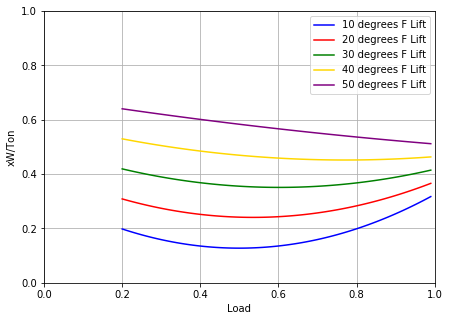

In [6]:
lift_lines = compute_lift_lines(lr, feat, df1)

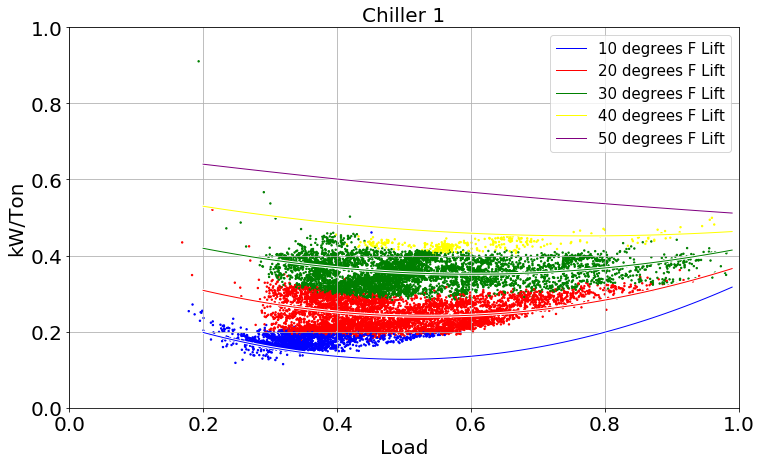

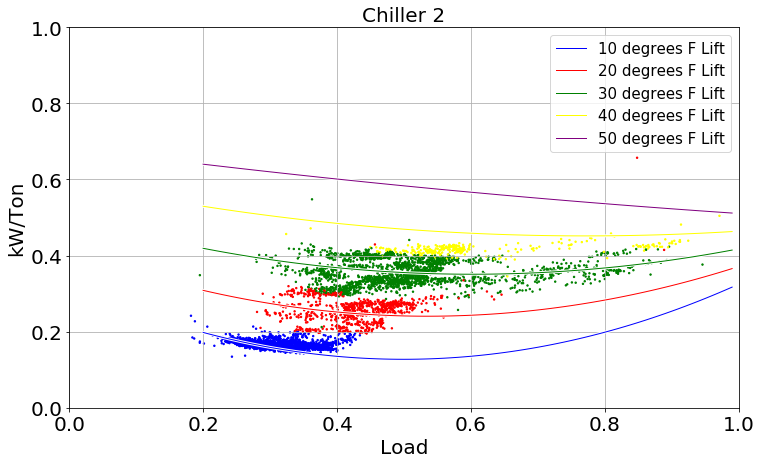

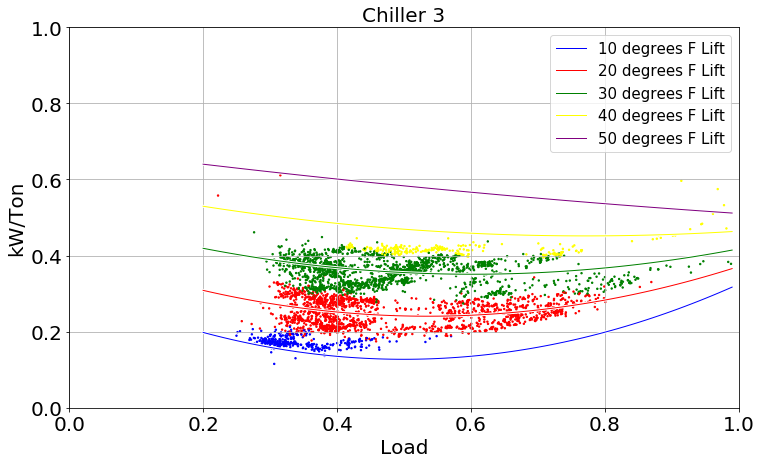

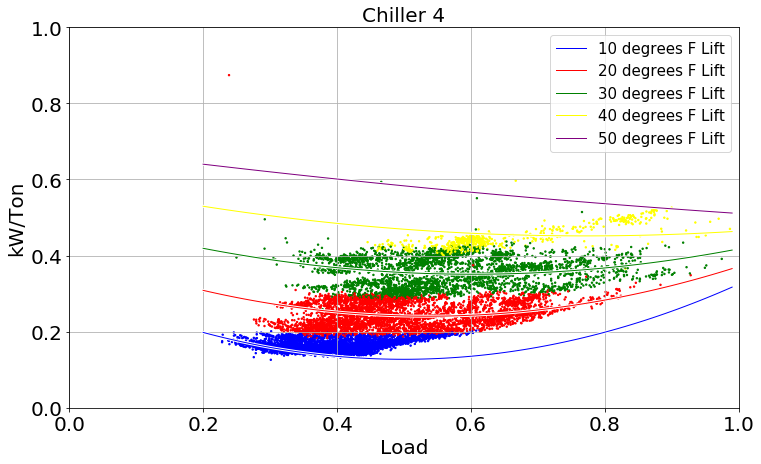

In [8]:
plot_curves(df1,lift_lines,'Chiller 1')
plot_curves(df2,lift_lines,'Chiller 2')
plot_curves(df3,lift_lines,'Chiller 3')
plot_curves(df4,lift_lines,'Chiller 4')

In [ ]:
pickle.dump(lift_lines,open('lift_lines.pkl','wb'))

In [ ]:
# get rid of bad points
print(df2.shape)
df2 = df2[df2['Load'] > 0.2]
print(df2.shape)

print(df3.shape)
df3 = df3[df3['Load'] > 0.2]
print(df3.shape)


## BCBS

In [9]:
#feat = ['AddOther','HigherOrder']
feat = ['HigherOrder']

data_file = 'data/B1_chiller.csv'
X_train, y_train, df1 = get_Xy(data_file,feat)
print('CH1:',X_train.shape,y_train.shape)

data_file = 'data/B2_chiller.csv'
X_train, y_train, df2 = get_Xy(data_file,feat)
print('CH2:',X2_test.shape,y2_test.shape)

data_file = 'data/B3_chiller.csv'
X3_test, y3_test, df3 = get_Xy(data_file,feat)
print('CH3:',X3_test.shape,y3_test.shape)

data_file = 'data/B4_chiller.csv'
X4_test, y4_test, df4 = get_Xy(data_file,feat)
print('CH4:',X4_test.shape,y4_test.shape)

DataFrame size before removing NaN: (33724, 14)
DataFrame size after removing NaN:  (33576, 14)
CH1: (33576, 5) (33576,)


/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load^2'] = df['Load']**2
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load*DTLift'] = df['Load']*df['DTLift']
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

DataFrame size before removing NaN: (36343, 14)
DataFrame size after removing NaN:  (36143, 14)
CH2: (5459, 5) (5459,)
DataFrame size before removing NaN: (29887, 14)
DataFrame size after removing NaN:  (29786, 14)
CH3: (29786, 5) (29786,)
DataFrame size before removing NaN: (23290, 14)
DataFrame size after removing NaN:  (23288, 14)
CH4: (23288, 5) (23288,)


0.2996128135365448
[-0.95396785  0.01851701  0.85542997 -0.00673272 -0.00265709]
train with B1: 0.8967321905157696
test with B2:  -0.33602417634885584
test with B3:  0.8556727069515556
test with B4:  0.6258042427089148


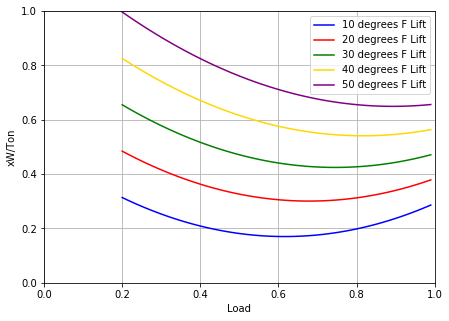

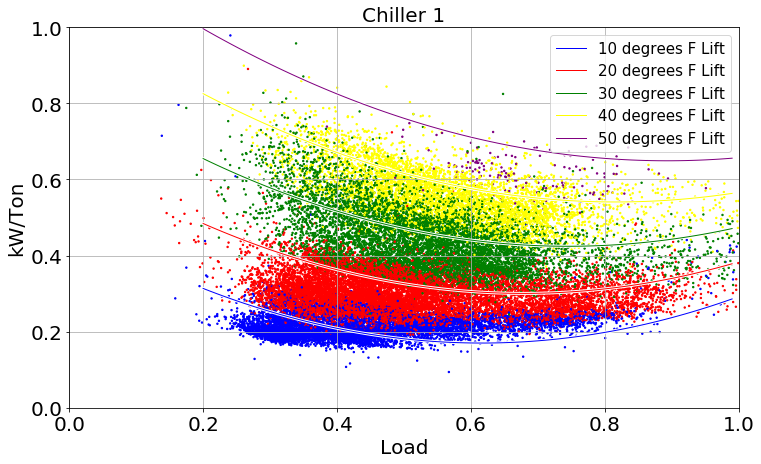

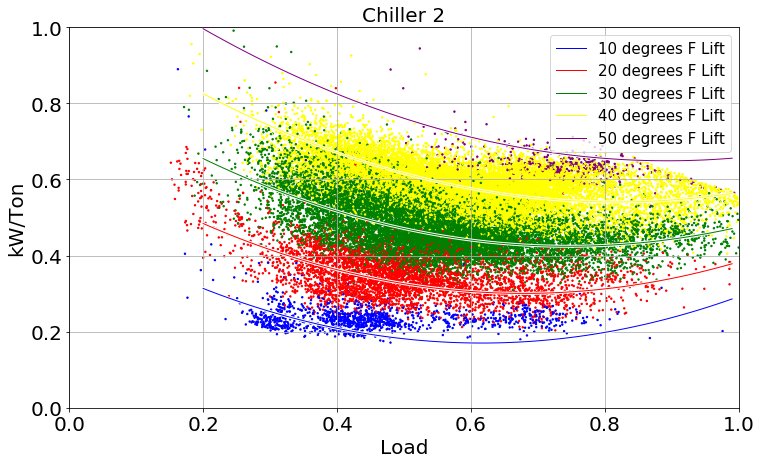

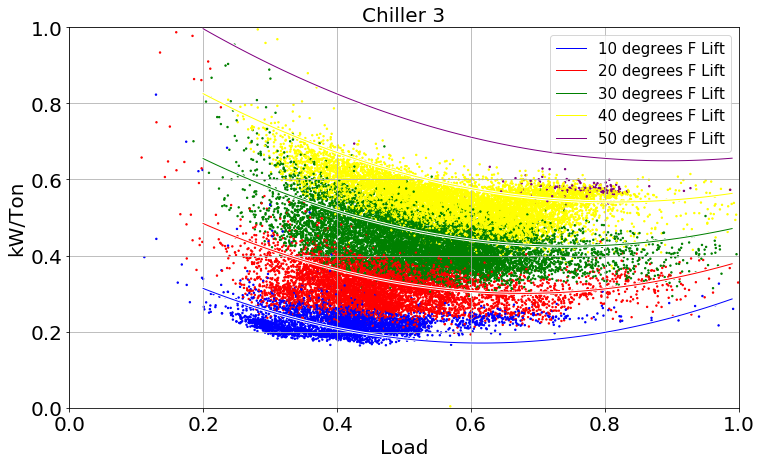

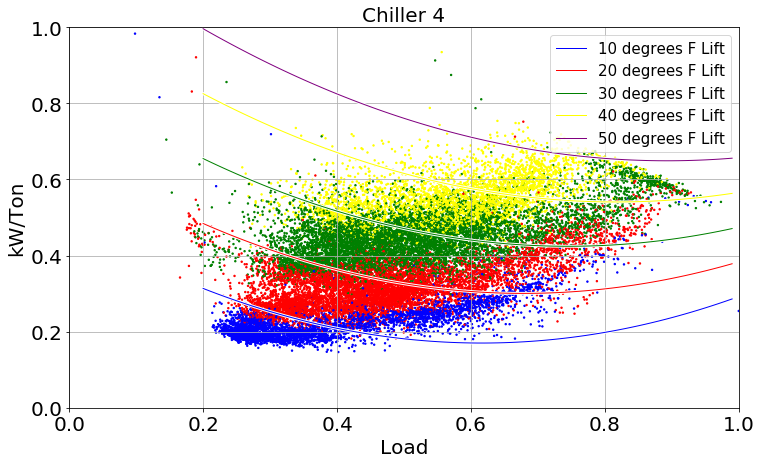

In [10]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

print('train with B1:',lr.score(X_train,y_train))
print('test with B2: ',lr.score(X2_test,y2_test))
print('test with B3: ',lr.score(X3_test,y3_test))
print('test with B4: ',lr.score(X4_test,y4_test))

lift_lines = compute_lift_lines(lr, feat, df2)

plot_curves(df1,lift_lines,'Chiller 1')
plot_curves(df2,lift_lines,'Chiller 2')
plot_curves(df3,lift_lines,'Chiller 3')
plot_curves(df4,lift_lines,'Chiller 4')

## CMH

In [11]:
#feat = ['AddOther','HigherOrder']
feat = ['HigherOrder']

data_file = 'data/C1_chiller.csv'
X_train, y_train, df1 = get_Xy(data_file,feat)
print('CH1:',X_train.shape,y_train.shape)

data_file = 'data/C2_chiller.csv'
X2_test, y2_test, df2 = get_Xy(data_file,feat)
print('CH2:',X2_test.shape,y2_test.shape)

data_file = 'data/C3_chiller.csv'
X3_test, y3_test, df3 = get_Xy(data_file,feat)
print('CH3:',X3_test.shape,y3_test.shape)

data_file = 'data/C4_chiller.csv'
X4_test, y4_test, df4 = get_Xy(data_file,feat)
print('CH4:',X4_test.shape,y4_test.shape)

DataFrame size before removing NaN: (36415, 14)
DataFrame size after removing NaN:  (34978, 14)
CH1: (34978, 5) (34978,)


/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load^2'] = df['Load']**2
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load*DTLift'] = df['Load']*df['DTLift']
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

DataFrame size before removing NaN: (35045, 14)
DataFrame size after removing NaN:  (25166, 14)
CH2: (25166, 5) (25166,)
DataFrame size before removing NaN: (46343, 14)
DataFrame size after removing NaN:  (41276, 14)
CH3: (41276, 5) (41276,)
DataFrame size before removing NaN: (45490, 14)
DataFrame size after removing NaN:  (43362, 14)
CH4: (43362, 5) (43362,)


0.21118535431971222
[-5.31187708e-01  1.00104443e-02  4.59217592e-01 -2.03717941e-03
 -4.49363924e-04]
train with C1: 0.9706617554871686
test with C2:  0.6313079691370411
test with C3:  0.7820107557684952
test with C4:  0.8482267243153245


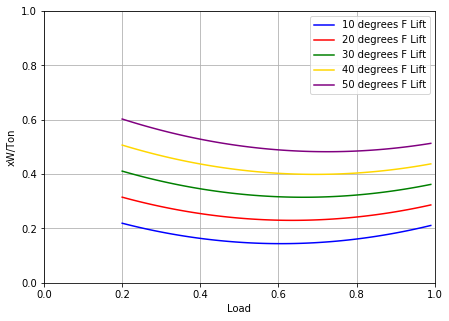

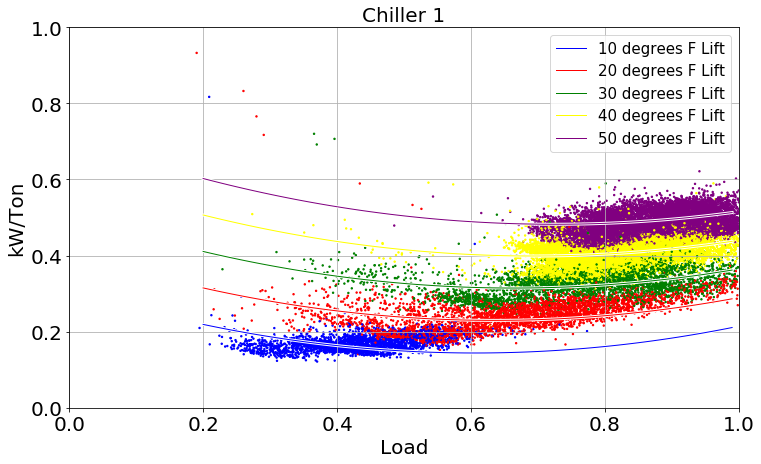

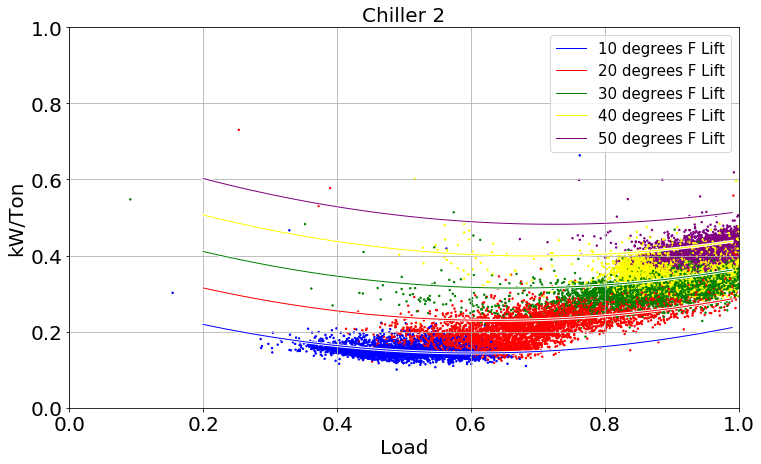

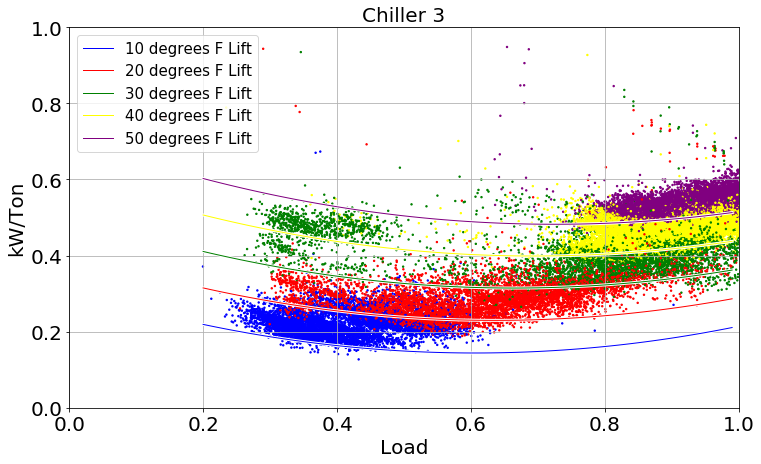

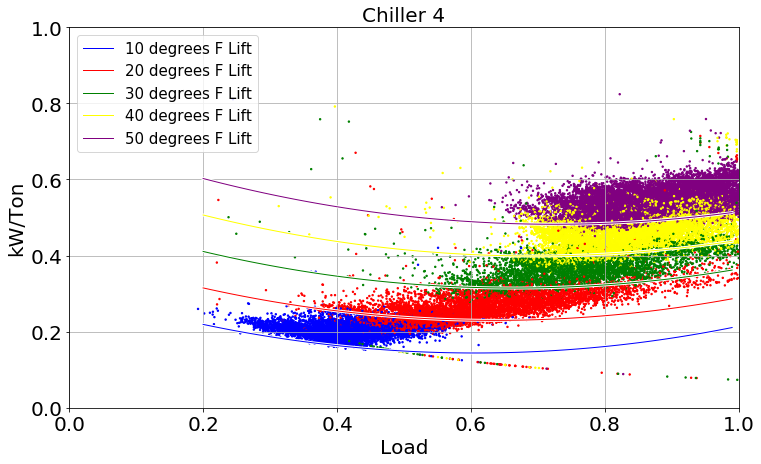

In [12]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

print('train with C1:',lr.score(X_train,y_train))
print('test with C2: ',lr.score(X2_test,y2_test))
print('test with C3: ',lr.score(X3_test,y3_test))
print('test with C4: ',lr.score(X4_test,y4_test))

lift_lines = compute_lift_lines(lr, feat, df2)

plot_curves(df1,lift_lines,'Chiller 1')
plot_curves(df2,lift_lines,'Chiller 2')
plot_curves(df3,lift_lines,'Chiller 3')
plot_curves(df4,lift_lines,'Chiller 4')

## Things to try

Random Forest Regression